In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install py4j==0.10.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.5/196.5 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.appName("EmotionRecognition").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.truncate", 5000)
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CC Project/dataset/fer2013.csv')

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.shape

(35887, 3)

In [ ]:
labels = data.iloc[:, 0]

In [ ]:
pixels = data.iloc[:, 1]
images = np.zeros((pixels.shape[0], 48*48))
for ix in range(images.shape[0]):
    p = pixels[ix].split(' ')
    for iy in range(images.shape[1]):
        images[ix, iy] = int(p[iy])

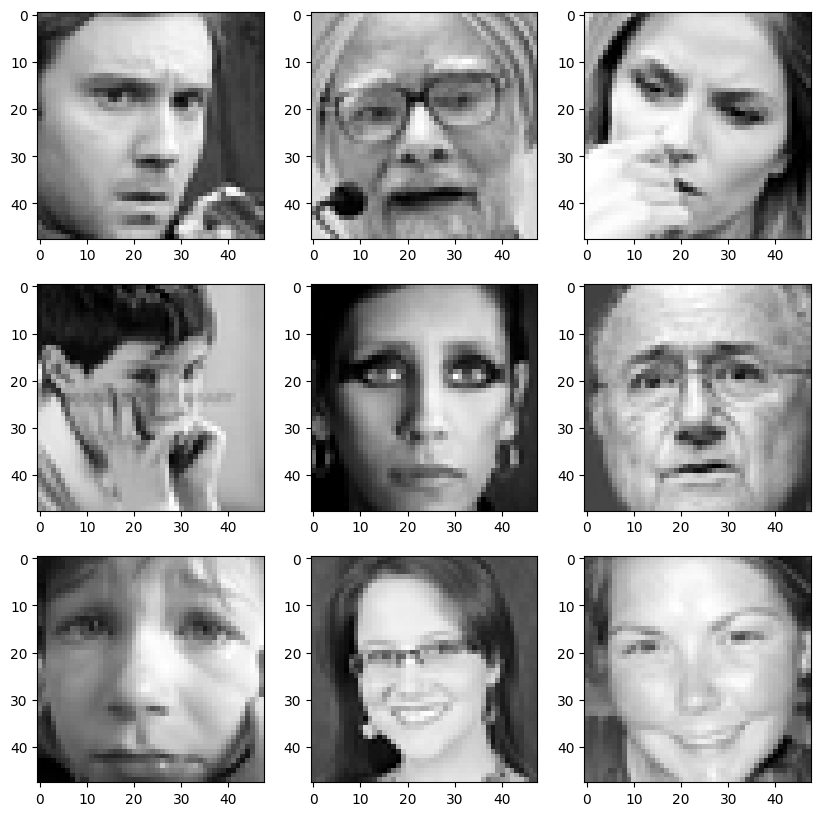

In [ ]:
plt.figure(figsize = (10,10))
for index,image in enumerate(images[:9]):
    plt.subplot(3,3,index+1)
    plt.imshow(image.reshape((48,48)), cmap = 'gray')
plt.show()

In [ ]:
train_or_test = data.iloc[:, 2].values
data["Usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [ ]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
reshaped_images = np.zeros((images.shape[0], 48, 48,1))
i = 0
for image in images:
  reshaped_images[i] = image.reshape((48,48,1))
  i+=1

In [ ]:
reshaped_images.shape

(35887, 48, 48, 1)

In [ ]:
norm_images = reshaped_images / 255.0

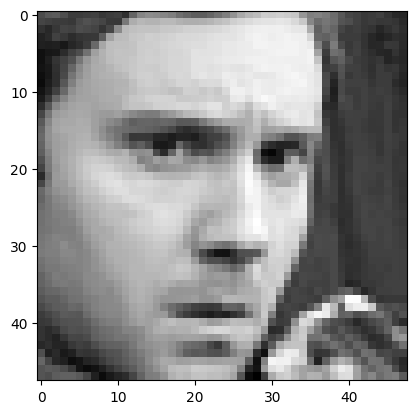

In [ ]:
plt.imshow(norm_images[0].reshape((48,48)), cmap="gray")
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
new_labels = to_categorical(labels, num_classes=7)
new_labels.shape

(35887, 7)

In [ ]:
reshaped_images.shape

(35887, 48, 48, 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(norm_images, new_labels, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709, 7), (7178, 7))

In [ ]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding = "same", input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation = "softmax"))

In [ ]:
opt = Adam(lr = 0.0005)

model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [ ]:
epochs = 50

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

checkpoint = ModelCheckpoint("fer_model.h5", monitor='val_loss',
                             mode='max', verbose=1)

callbacks = [checkpoint, reduce_lr]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=callbacks, epochs = epochs)

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 1.6915 - accuracy: 0.3513
Epoch 1: saving model to fer_model.h5
898/898 [==============================] - 39s 25ms/step - loss: 1.6915 - accuracy: 0.3513 - val_loss: 1.5069 - val_accuracy: 0.4079 - lr: 0.0010
Epoch 2/50
  1/898 [..............................] - ETA: 21s - loss: 1.2481 - accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


896/898 [============================>.] - ETA: 0s - loss: 1.3519 - accuracy: 0.4821
Epoch 2: saving model to fer_model.h5
898/898 [==============================] - 22s 24ms/step - loss: 1.3515 - accuracy: 0.4823 - val_loss: 1.3689 - val_accuracy: 0.4863 - lr: 0.0010
Epoch 3/50
897/898 [============================>.] - ETA: 0s - loss: 1.2404 - accuracy: 0.5276
Epoch 3: saving model to fer_model.h5
898/898 [==============================] - 21s 23ms/step - loss: 1.2404 - accuracy: 0.5275 - val_loss: 1.1671 - val_accuracy: 0.5548 - lr: 0.0010
Epoch 4/50
896/898 [============================>.] - ETA: 0s - loss: 1.1757 - accuracy: 0.5547
Epoch 4: saving model to fer_model.h5
898/898 [==============================] - 22s 24ms/step - loss: 1.1754 - accuracy: 0.5548 - val_loss: 1.2360 - val_accuracy: 0.5351 - lr: 0.0010
Epoch 5/50
898/898 [==============================] - ETA: 0s - loss: 1.1156 - accuracy: 0.5773
Epoch 5: saving model to fer_model.h5
898/898 [============================

In [ ]:
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

In [ ]:
import PIL
from PIL import Image

In [ ]:
import cv2

In [ ]:
img = cv2.imread("/content/drive/MyDrive/CC Project/images/sad.jpg")

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
img.shape

(1200, 1600)

In [ ]:
img = cv2.resize(img, (48,48))

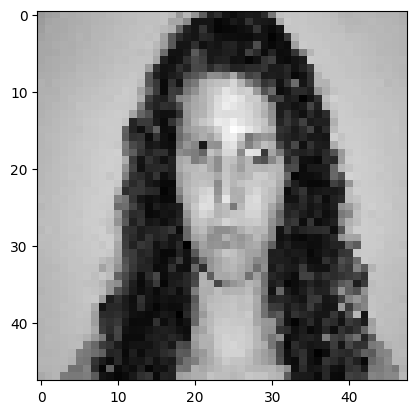

In [ ]:
plt.imshow(img, cmap='gray')

In [ ]:
np.argmax(model.predict(img.reshape((1,48,48,1))), axis=-1)[0]

1/1 [==============================] - 0s 348ms/step


0

In [ ]:
model.save("/content/drive/MyDrive/CC Project/model/Fer_Model.h5")

In [ ]:
model.save_weights("/content/drive/MyDrive/CC Project/model/model_weights.h5")

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/CC Project/model/model.json", "w") as json_file:
    json_file.write(model_json)

**Model Architecture Description:**

The model architecture constitutes a Convolutional Neural Network (CNN) tailored for image-based classification tasks. Comprising multiple convolutional layers followed by batch normalization, rectified linear unit (ReLU) activation functions, and dropout layers, this design aims to capture intricate patterns within input images. Max-pooling layers are interspersed to downsample feature maps, reducing computational load and extracting essential information. Dense layers with varying neuron counts and dropout regularization are employed for effective classification. The model is compiled using the Adam optimizer, categorical cross-entropy loss, and accuracy metrics. During training, adaptive learning rate reduction and model checkpointing strategies are implemented through callbacks.

This model achieves accuracy of 0.7652

Overall, this architecture stands as a generic blueprint suitable for image classification tasks, leveraging convolutional and dense layers for feature extraction and classification.

**Below is the model architecture:**

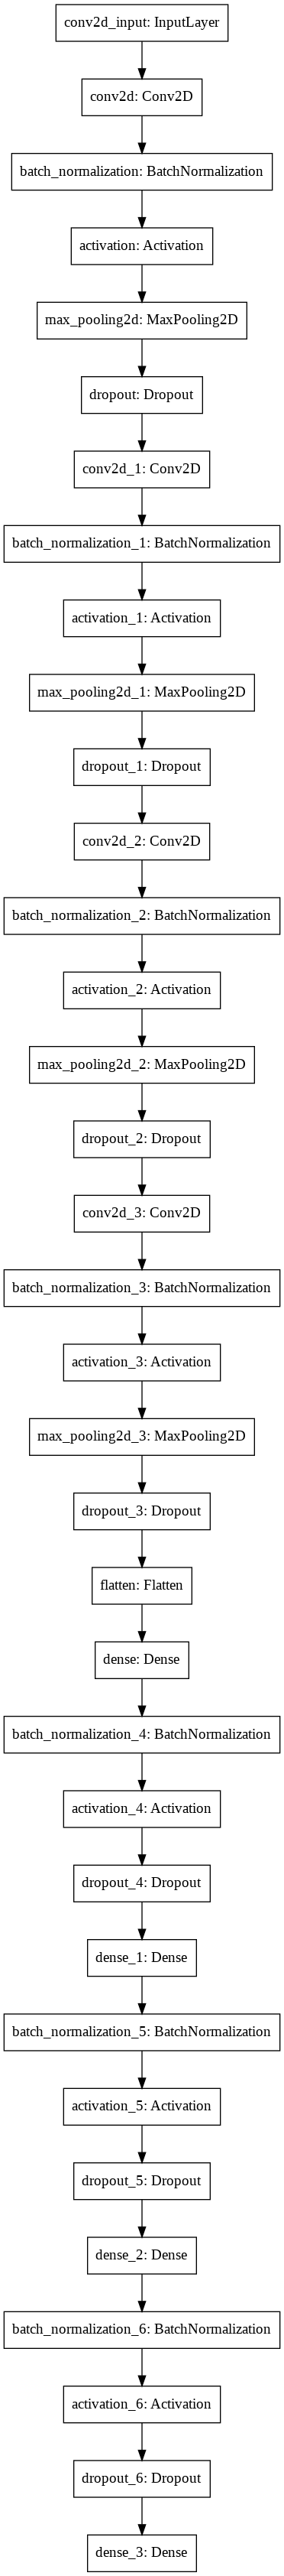